In [48]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import shutil

data_dir = 'C://Users//johnl//Documents//GitHub//avoChecker//Quality'

In [49]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Keras will automatically grab all the images from the directory and label them as per the folders

In [50]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size= 10, shuffle= 12453432 )

Found 246 files belonging to 11 classes.


This just lets us see some of the images with their assigned labels

In [51]:
data_iterator = data.as_numpy_iterator()

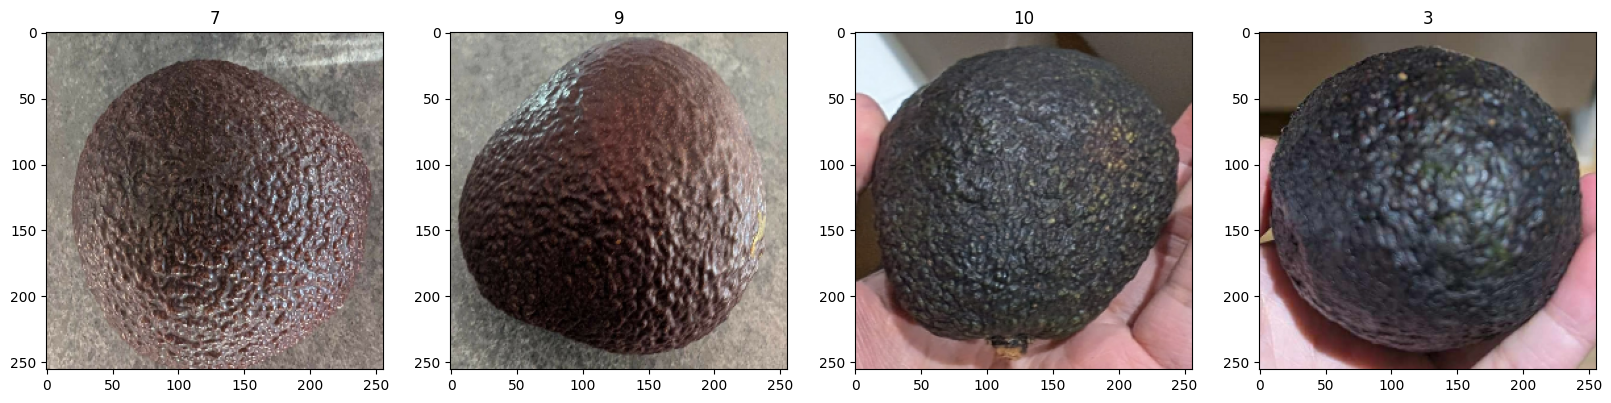

In [52]:
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The data for the images is currently 0 - 255 (since the images are 256 x 256). We are scaling down the data to be 0-1 so that the processing is much faster

In [53]:
data = data.map(lambda x,y: (x/255, y))

In [54]:
batch = data.as_numpy_iterator().next()

This is just to visualise the images again after they have been resized but don't really need it

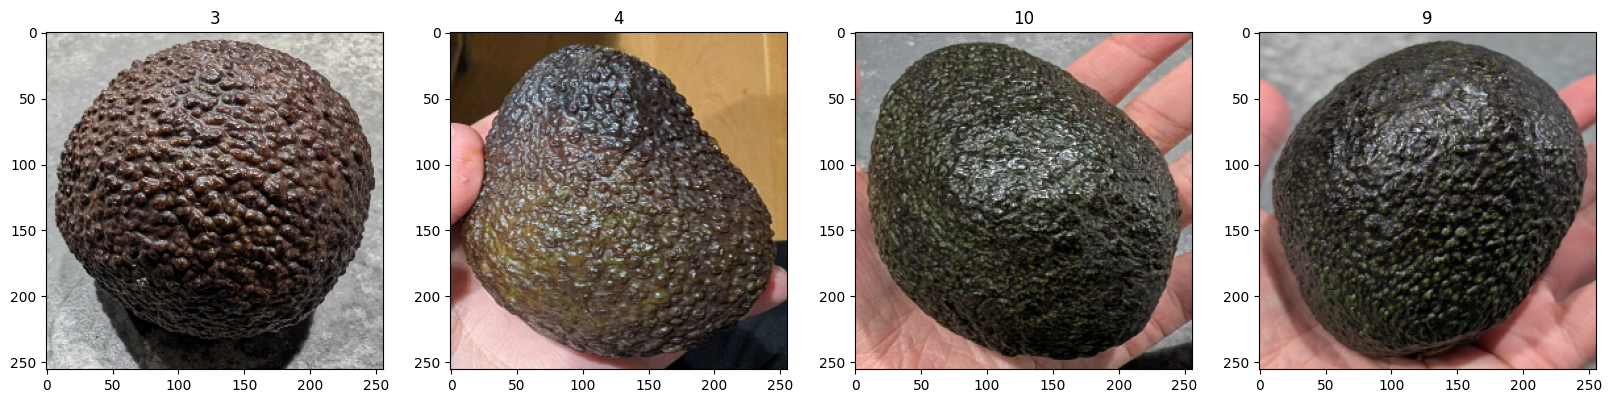

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Next we create the training/testing/validation sets. This first block just allocates the number of batches we use for each set. It is important to note that if you have not yet shuffled your data, you have to do that before you generate the sets.

In [56]:
train_size = int(len(data)*.7) -1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) +1

In [57]:
test_size

3

Next we're allocating batches to the training/testing/validation sets

In [58]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building the model

Import the layers and model type from keras, define the model and then add the layers

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD

In [60]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
#model.add(Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)))
#model.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

In [61]:
epochs = 100
lrate = 0.002
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)

#model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])



In [62]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,081 (1.59 MB)

 Trainable params: 418,081 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [63]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
hist = model.fit(train,  epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 486ms/step - loss: 22.3860 - mae: 3.9962 - val_loss: 11.1267 - val_mae: 2.9627
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 469ms/step - loss: 12.2679 - mae: 2.8555 - val_loss: 12.6567 - val_mae: 3.2360
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 494ms/step - loss: 12.0966 - mae: 2.9592 - val_loss: 11.6829 - val_mae: 3.0863
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - loss: 10.1424 - mae: 2.7042 - val_loss: 9.6046 - val_mae: 2.7793
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - loss: 7.6969 - mae: 2.2928 - val_loss: 8.6192 - val_mae: 2.4075
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - loss: 9.1373 - mae: 2.4418 - val_loss: 8.8937 - val_mae: 2.5864
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 479ms/step - loss: 8.5216 - mae: 2.4202 - val_loss: 16.6674 - val_mae: 3.5862
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 490ms/step - loss: 12.3163 - mae: 3.0278 - val_loss: 6.9249 - val_mae: 2.1381
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/ste

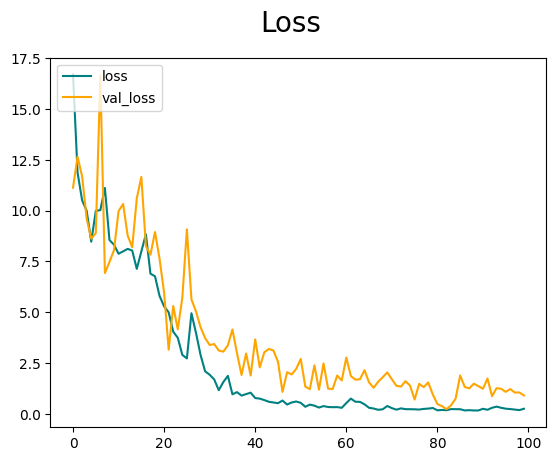

In [65]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

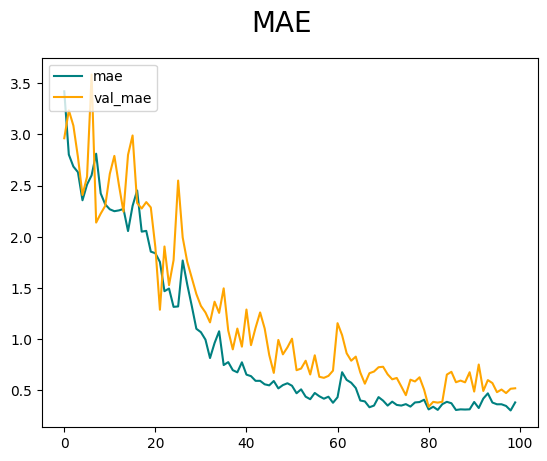

In [66]:
fig = plt.figure()
plt.plot(hist.history['mae'], color='teal', label='mae')
plt.plot(hist.history['val_mae'], color='orange', label='val_mae')
fig.suptitle('MAE', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluate

By testing on the test set

In [67]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [68]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

actual_labels = []
predicted_values = []  # Changed to predicted_values to store unrounded preds

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X).flatten()  # Get the float prediction, and flatten to 1d array.

    # Store actual labels and unrounded predictions
    actual_labels.extend(y)
    predicted_values.extend(yhat)  # Store unrounded yhat

# Print the results
for actual, predicted in zip(actual_labels, predicted_values):
    print(f"Actual: {actual}, Predicted: {predicted}")

results_df = pd.DataFrame({'Actual': actual_labels, 'Predicted': predicted_values})
print(results_df)
print(results_df.head(20))

# Convert lists to NumPy arrays for scikit-learn metrics
y_true = np.array(actual_labels)
y_pred = np.array(predicted_values) #Use unrounded predictions

# Retrieve metrics (using regression metrics)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Actual: 7, Predicted: 6.935108661651611
Actual: 6, Predicted: 7.900965213775635
Actual: 4, Predicted: 3.657526969909668
Actual: 7, Predicted: 7.611649036407471
Actual: 6, Predicted: 6.2853922843933105
Actual: 7, Predicted: 7.157856464385986
Actual: 7, Predicted: 7.757885456085205
Actual: 6, Predicted: 6.052546977996826
Actual: 7, Predicted: 7.247298717498779
Actual: 6, Predicted: 6.151203632354736
Actual: 6, Predicted: 6.640425205230713
Actual: 7, Predicted: 6.849421977996826
Actual: 6, Predicted: 6.122185230255127
Actual: 5, Predicted: 5.682611465454102
Actual: 2, Predicted: 2.6244335174560547
Actual: 4, Predicted: 4.361684322357178
Actual: 4, Predicted: 4.344186782836914
Actual: 2, Predicted: 2.0622406005859375
Actual: 4, Predicted: 4.205939769744873
Actual: 10, Predicted: 10.425566673278809
Actual: 2, Predicted: 2.3104734420776367
Actual: 5, Predicted: 5.1514496803283

Up next: Think I need to convert the labels to ints, and then find out what the best loss function is for ints

In [70]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X).flatten()
    print("Raw Predictions:", yhat)  # Print the raw predictions
    yhat_classes = np.round(yhat).astype(int)
    # ... rest of the code ...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Raw Predictions: [ 6.849422   7.611649   0.         9.445081  10.425567   6.209867
  6.4641976  6.302437   4.927545   9.312411 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Raw Predictions: [9.233402  6.6511893 9.397606  3.3359542 7.066803  6.334908  9.476346
 2.0622406 2.3104734 6.122185 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Raw Predictions: [ 7.5617642  6.640425   2.7477474  9.553494   9.37334    2.491139
  7.7519     7.624267  10.552583   9.096566 ]


Testing on unseen images. Cropped and uncropped versions

In [71]:
img = cv2.imread('Quality\\1\\490998267_1782034399031606_5012052412022513373_n.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy())
plt.show()

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

Saving the model

In [72]:
from tensorflow.keras.models import load_model #save full version of model
model.save('avo_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_lite = converter.convert()
with open("avo_model.tflite", "wb") as f:
    f.write(model_lite)

INFO:tensorflow:Assets written to: C:\Users\johnl\AppData\Local\Temp\tmp4gyoqhjh\assets


INFO:tensorflow:Assets written to: C:\Users\johnl\AppData\Local\Temp\tmp4gyoqhjh\assets


Saved artifact at 'C:\Users\johnl\AppData\Local\Temp\tmp4gyoqhjh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1756909760400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759344540752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759344540560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759344541136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759344540176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1756909760592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759344541520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759383225936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759383225744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1759383226704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1